# Hierarchical model fit on Splatter datasets

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
import scipy
from utils import loadStan, hierarchical_model, est_k
sns.set()
from sklearn.metrics import adjusted_rand_score
import csv
import math
import time

ppca_model = loadStan('ppca')
gmm_model = loadStan('gmm')
moppcas_model = loadStan('moppcas')
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.


## Splatter 1 (small and simple)

## Loading data

In [71]:
with open('../Splatter/smallsplat.csv') as file:
    text = csv.reader(file)
    data = np.array(np.array(list(text))[1:,1:].T, dtype=int)
with open('../Splatter/smallsplat_labels.csv') as file:
    text = csv.reader(file)
    labels_raw = np.array(list(text))
    labels = np.unique(labels_raw[1:,1], return_inverse=True)[1]

In [72]:
print(data[:6,:6])
print(labels[:6])

[[ 38   0   3   4  24   2]
 [  8   4   0  17  12   2]
 [ 34   0   2  14  52   2]
 [ 22   0   0  20  43   0]
 [ 25   0   3   8  20   5]
 [ 58   1   8   1 100  15]]
[3 3 0 0 3 1]


In [73]:
ct, ct_count = np.unique(labels, return_counts=True)
for i,j in zip(ct, ct_count):
    print(i,'\t',j)

0 	 95
1 	 116
2 	 88
3 	 98
4 	 103


### Loading/Saving  formatted data

In [74]:
# with open('splat_small.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [17]:
data, labels = pickle.load(open('splat_small.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(500, 400)


## Pre-analysis

### Some explames of distributions of genes

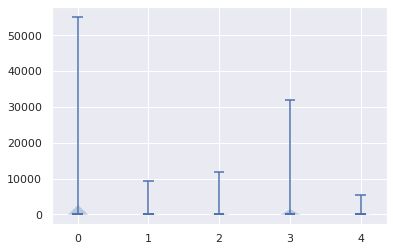

In [76]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]

sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

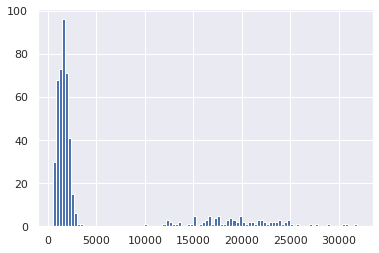

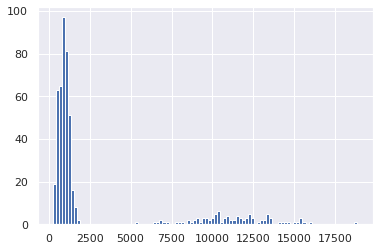

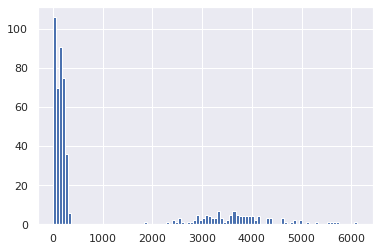

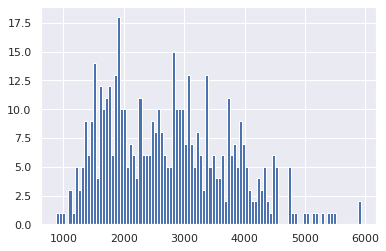

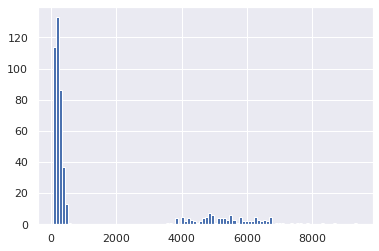

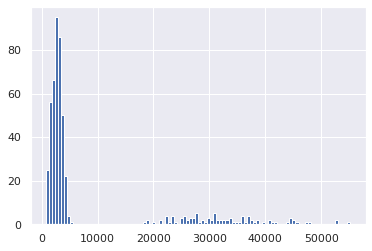

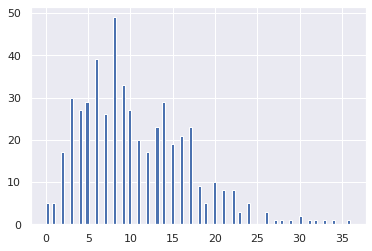

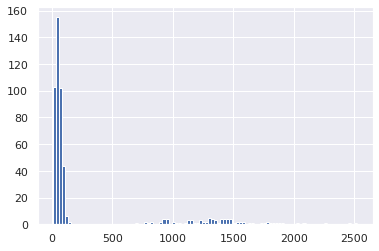

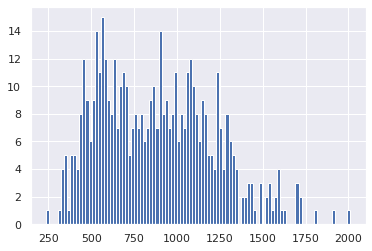

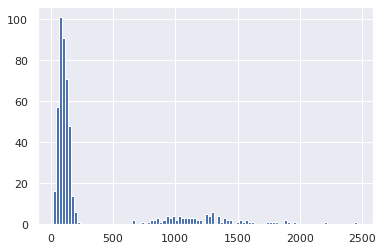

In [77]:
genes = np.random.choice(list(range(D)), p= np.std(data,axis=0)/sum(np.std(data,axis=0)), size=10, replace=False)
for i in range(10):
    plt.hist(data[:,genes[i]], bins=100)
    plt.show()

## Preprocessing

### Transform data

In [18]:
trans_data = np.log2(data+1)

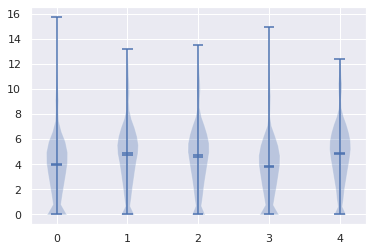

In [79]:
plotdata = [np.concatenate(trans_data[labels==i,:]) for i in range(len(set(labels)))]
sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

We remove the genes that are not or barely measured in the dataset to reduce the computational cost.

### Impact of filtering

In [19]:
order = np.argsort(np.std(data, axis=0))
data = data[:,order]

In [20]:
scores = []
rang = np.linspace(0,6,500)
stds = np.std(trans_data, axis=0)
for i in rang:
    scores.append(sum(stds>i))

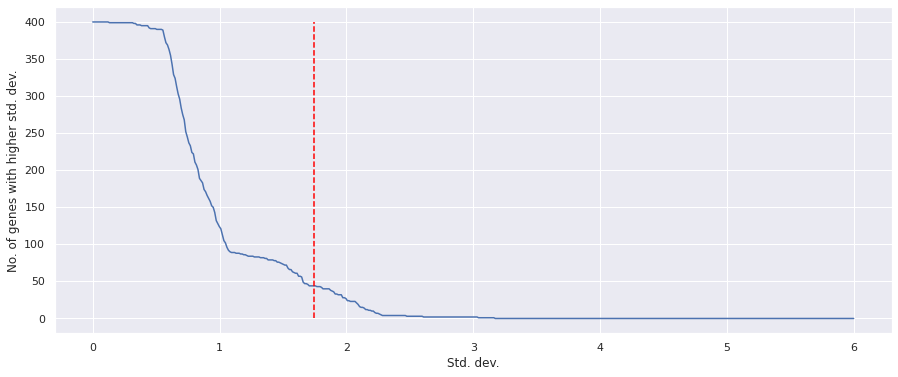

In [25]:
sns.set()
plt.figure(figsize=(15,6))
plt.ylabel('No. of genes with higher std. dev.')
plt.xlabel('Std. dev.')
plt.plot(rang, scores)
plt.plot([rang[145],rang[145]], [0,scores[0]], c = 'red', linestyle='--')
plt.show()

In [24]:
thres = 145
genemask = []
for i in range(D):
    if np.std(trans_data[:,i])>rang[thres]:
        genemask.append(True)
    else:
        genemask.append(False)
genemask = np.array(genemask)
print('Using %i genes with std.dev. of higher than %s'%(int(scores[thres]),str(rang[thres])))

Using 44 genes with std.dev. of higher than 1.7434869739478958


In [26]:
data = trans_data[:,genemask]

In [27]:
np.shape(data)

(500, 44)

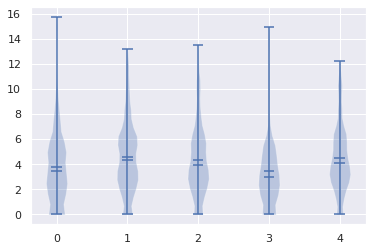

In [15]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]
sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

### Loading/Saving  preprocessed data

In [16]:
# with open('smallsplat_prep.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [2]:
data, labels = pickle.load(open('smallsplat_prep.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(500, 113)


### Number of clusters is estimated fairly high

In [104]:
K, _ = est_k(data, k_max = 25, verbose=False, method='bic', refs=3)
print('Estimated number of clusters: ',K)

17  clusters according to AIC,  10  clusters according to BIC.
Estimated number of clusters:  10


### Clear classes can be observed

In [106]:
n_test = 5
labels_test = KMeans(n_test).fit(data).labels_

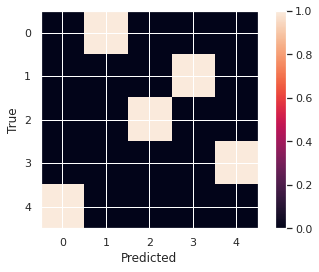

In [107]:
res = np.zeros((5,n_test))
for r in range(5):
    for t in range(n_test):
        res[r,t] = sum(labels[labels_test==t]==r)
    res[r,:] = res[r,:]/sum(res[r,:])
sns.set()
plt.imshow(res, label='Percentage samples')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [108]:
adjusted_rand_score(labels, labels_test)

1.0

## Analysis

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Latent data on top level:


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Estimated number of clusters (level 0):  3


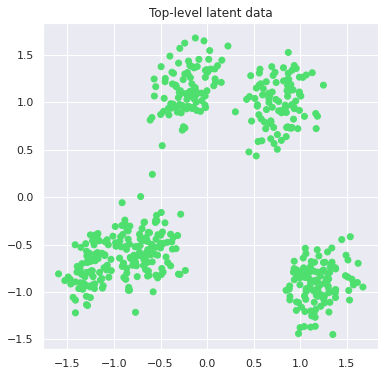

level  1 :


In [ ]:
model = hierarchical_model()
latent, cats_per_lvl, probs = model.fit(data, max_depth=5, k_max=3)

In [7]:
k_test = 3
N,D = np.shape(data)
M = 2
moppcas_dat = {'N':N, 'M':M,'K':k_test, 'D':D, 'y':data, 'weights':np.ones(N)}

In [8]:
kmns = KMeans(k_test).fit(data)

In [16]:
fit = moppcas_weighted.sampling(data=moppcas_dat, chains=1,iter=500,init=[{'mu':kmns.cluster_centers_,'theta':[sum(kmns.labels_==i)/N for i in range(k_test)],
                                                                            'z':[np.zeros((2,N)) for i in range(k_test)],
                                                                             'sigma':np.ones(k_test)}])

RuntimeError: Initialization failed.

In [ ]:
fit2 = moppcas_weighted.sampling(data=moppcas_dat, chains=1, iter=500, init=[{'mu':kmns.cluster_centers_, 'theta':[sum(kmns.labels_==i)/N for i in range(2)],
                                                                            'z':[np.zeros((2,N)) for i in range(2)]}])

In [ ]:
fit3 = moppcas_weighted.sampling(data=moppcas_dat, chains=1, iter=500, init=[{'mu':kmns.cluster_centers_,'theta':[sum(kmns.labels_==i)/N for i in range(2)]}])

In [ ]:
fit4 = moppcas_weighted.sampling(data=moppcas_dat, chains=1, iter=500, init=[{'mu':kmns.cluster_centers_}])

In [ ]:
fit5 = moppcas_weighted.sampling(data=moppcas_dat, chains=1, iter=500, init=[{'mu':kmns.cluster_centers_,'z':[np.zeros((2,N)) for i in range(2)]}])

## Splatter 2 (Larger and more complex)

## Loading data

In [44]:
with open('../Splatter/bigsplat.csv') as file:
    text = csv.reader(file)
    data = np.array(np.array(list(text))[1:,1:].T, dtype=int)
with open('../Splatter/bigsplat_labels.csv') as file:
    text = csv.reader(file)
    labels_raw = np.array(list(text))
    labels = np.unique(labels_raw[1:,1], return_inverse=True)[1]

In [45]:
print(data[:6,:6])
print(labels[:6])

[[152  14  30  64   2 256]
 [ 88   6  12  46   0 198]
 [165  28  21  94   8 404]
 [129  32  39  54   1 364]
 [107  17  22  38   4 302]
 [104  23  22  44   3 229]]
[5 2 5 4 4 4]


In [47]:
ct, ct_count = np.unique(labels, return_counts=True)
for i,j in zip(ct, ct_count):
    print(i,'\t',j)

0 	 126
1 	 59
2 	 49
3 	 11
4 	 245
5 	 110


### Loading/Saving  formatted data

In [48]:
# with open('big_splat.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [49]:
data, labels = pickle.load(open('big_splat.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(600, 400)


## Pre-analysis

In [80]:
set(labels)

{0, 1, 2, 3, 4, 5}

### Some explames of distributions of genes

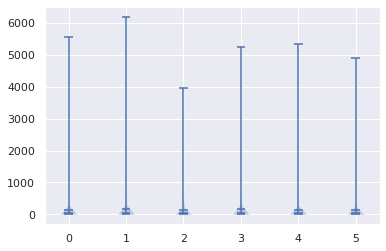

In [50]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]

sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

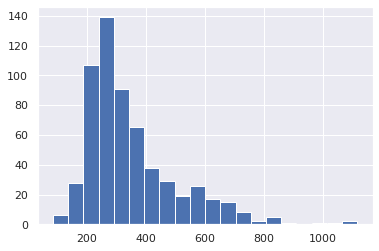

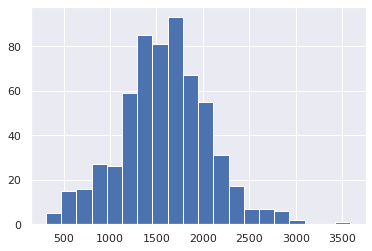

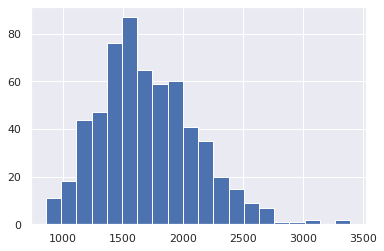

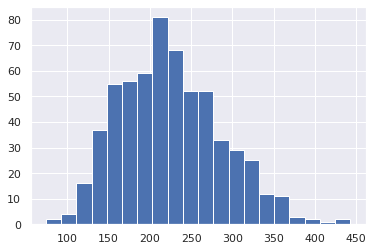

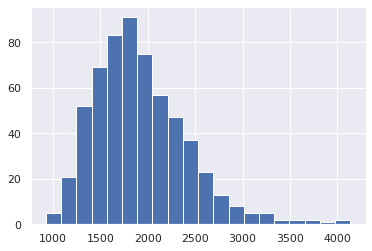

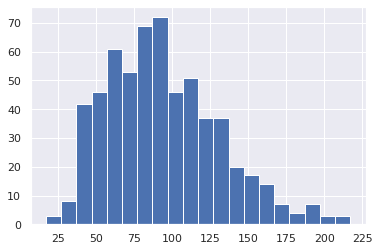

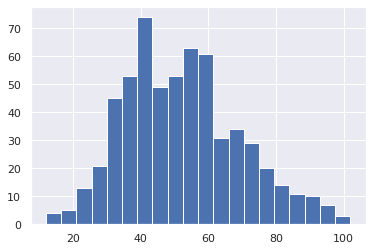

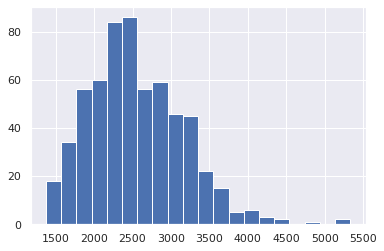

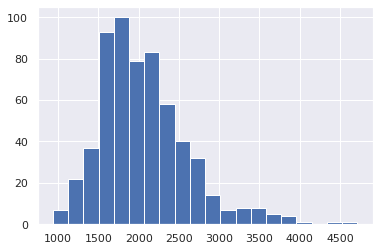

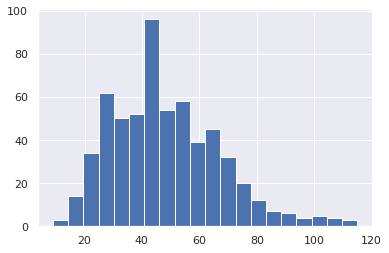

In [51]:
genes = np.random.choice(list(range(D)), p= np.std(data,axis=0)/sum(np.std(data,axis=0)), size=10, replace=False)
for i in range(10):
    plt.hist(data[:,genes[i]], bins=20)
    plt.show()

## Preprocessing

### Transform data

In [52]:
trans_data = np.log2(data+1)

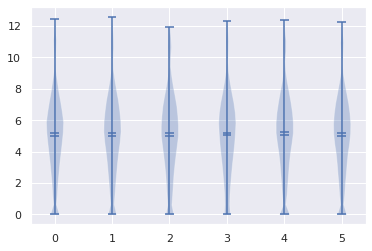

In [53]:
plotdata = [np.concatenate(trans_data[labels==i,:]) for i in range(len(set(labels)))]
sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

We remove the genes that are not or barely measured in the dataset to reduce the computational cost.

### Impact of filtering

In [54]:
order = np.argsort(np.std(data, axis=0))
data = data[:,order]

In [65]:
scores = []
rang = np.linspace(0,2,500)
stds = np.std(trans_data, axis=0)
for i in rang:
    scores.append(sum(stds>i))

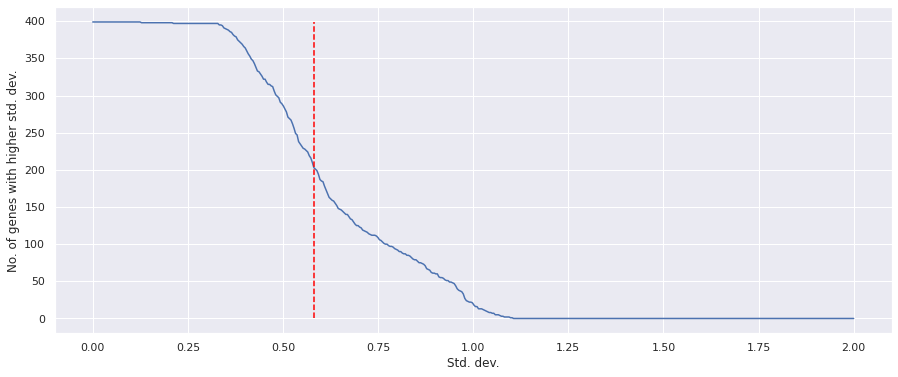

In [71]:
sns.set()
plt.figure(figsize=(15,6))
plt.ylabel('No. of genes with higher std. dev.')
plt.xlabel('Std. dev.')
plt.plot(rang, scores)
plt.plot([rang[145],rang[145]], [0,scores[0]], c = 'red', linestyle='--')
plt.show()

In [70]:
thres = 145
genemask = []
for i in range(D):
    if np.std(trans_data[:,i])>rang[thres]:
        genemask.append(True)
    else:
        genemask.append(False)
genemask = np.array(genemask)
print('Using %i genes with std.dev. of higher than %s'%(int(scores[thres]),str(rang[thres])))

Using 203 genes with std.dev. of higher than 0.5811623246492985


In [72]:
data = trans_data[:,genemask]

238

In [73]:
np.shape(data)

(600, 203)

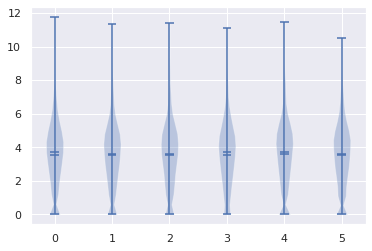

In [74]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]
sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

### Loading/Saving  preprocessed data

In [75]:
# with open('smallsplat_prep.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [76]:
data, labels = pickle.load(open('smallsplat_prep.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(600, 203)


### Number of clusters is estimated fairly high

In [84]:
K, _ = est_k(data, k_max = 25, verbose=False, method='bic', refs=3)
print('Estimated number of clusters: ',K)

Estimated number of clusters:  15


### Some classes can be observed

In [81]:
n_test = 6
labels_test = KMeans(n_test).fit(data).labels_

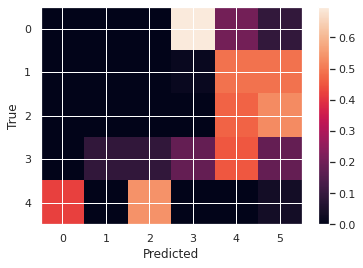

In [82]:
res = np.zeros((5,n_test))
for r in range(5):
    for t in range(n_test):
        res[r,t] = sum(labels[labels_test==t]==r)
    res[r,:] = res[r,:]/sum(res[r,:])
sns.set()
plt.imshow(res, label='Percentage samples')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [83]:
adjusted_rand_score(labels, labels_test)

0.483979716499772

## Analysis

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Latent data on top level:


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Estimated number of clusters (level 0):  2


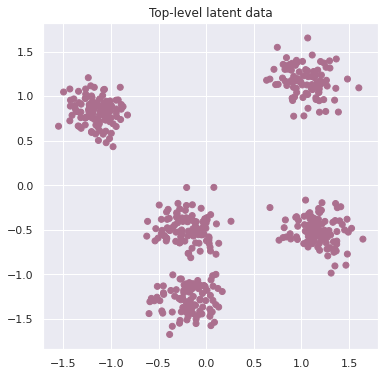

In [ ]:
model = hierarchical_model()
latent, cats_per_lvl, probs = model.fit(data, max_depth=5)

In [13]:
n_subs, subs = est_k(data, k_max = 2, gmm = False, refs = 1, weights=np.ones(465))

In [30]:
model.cats_per_lvl[-1]

array([0, 1, 2, 1, 1, 0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0,
       2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 0, 0, 1, 0, 2, 2, 2, 1, 0, 0, 1, 1,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 1, 0, 1, 2, 0, 0, 1, 0,
       2, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 3, 1, 1,
       3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 3, 1, 2, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 0,
       2, 0, 2, 1, 3, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1, 2, 2, 1, 2, 0, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       2, 2, 2, 2, 3, 0, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1,
       2, 1, 2, 0, 1, 1, 1, 3, 2, 0, 1, 1, 1, 1, 2,

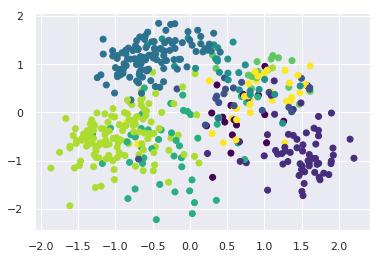

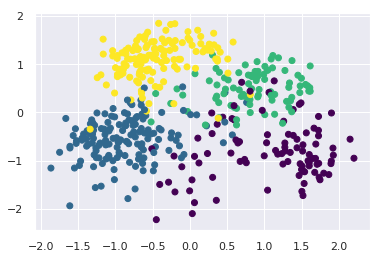

In [32]:
sns.set()
plt.scatter(model.latent[0][0][0,:],model.latent[0][0][1,:], c = labels, cmap='viridis')
plt.show()
plt.scatter(model.latent[0][0][0,:],model.latent[0][0][1,:], c = model.cats_per_lvl[-1], cmap='viridis')
plt.show()